# Lenet  CIFAR  adversarial training

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f
import sys
import torch.optim as optim
import os
sys.path.append('../utils')
from myUtils import my_fgsm

## lenet

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x, 2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_home = 'F:\\work'
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root=os.path.join(data_home, 'dataset/CIFAR10'), train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root=os.path.join(data_home, 'dataset/CIFAR10'), train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

# 对抗训练

In [5]:
# 读取正常模型

model_ADV = LeNet()
model_ADV = model_ADV.to(DEVICE)
model_adv_path = '../model/Lenet_CIFAR.pt'
model_ADV.load_state_dict(torch.load(model_adv_path))

criterion = nn.CrossEntropyLoss().to(DEVICE)

## test on clean data

In [6]:
model_ADV.eval()
test_loss = 0
test_correct = 0
total = 0
for batch_num, (data, target) in enumerate(test_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)
    output = model_ADV(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    prediction = torch.max(output, 1)
    total += target.size(0)
    test_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())
test_loss, test_correct / total
print('Test:   Loss:{}, Acc:{}'.format(test_loss, test_correct/total))

Test:   Loss:171.72881120443344, Acc:0.6674


## test on adv data(FGSM)

In [7]:
model_ADV.eval()

epsilon = 0.1
test_loss = 0
correct = 0
for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE)

    data, sign = my_fgsm(data, target, model_ADV, criterion, epsilon, DEVICE)

    output = model_ADV(data)
    test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    
test_loss /= len(test_loader.dataset)

print('Test:   Loss:{}, Acc:{}'.format(test_loss, correct/len(test_loader.dataset)))


Test:   Loss:13.323157792663574, Acc:0.0035


In [8]:
def imshow(img):
#     img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

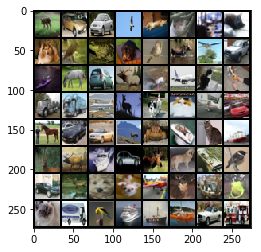

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


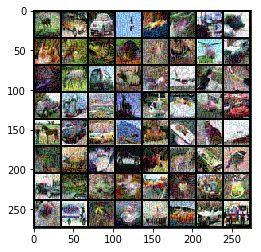

tensor([4, 1, 1, 2, 3, 3, 4, 3, 5, 2, 6, 5, 2, 4, 0, 1, 8, 7, 1, 4, 2, 0, 3, 5,
        9, 9, 0, 4, 5, 3, 0, 1, 7, 1, 1, 2, 6, 8, 3, 8, 4, 4, 8, 1, 4, 5, 8, 2,
        1, 4, 5, 5, 0, 4, 8, 6, 3, 9, 2, 8, 8, 8, 1, 9])


In [10]:
images, sign = my_fgsm(images, labels, model_ADV, criterion, 0.1, DEVICE)
imshow(torchvision.utils.make_grid(images.detach()))
print(labels)

## training

In [11]:
lr = 0.001
epochs = 2000

optimizer_ADV = optim.Adam(model_ADV.parameters(), lr=lr)
scheduler_ADV = optim.lr_scheduler.MultiStepLR(optimizer_ADV, milestones=[75. 150], gamma=0.5)
criterion_ADV = nn.CrossEntropyLoss().to(DEVICE)

In [ ]:

for epoch in range(epochs):

    train_loss = 0
    train_correct = 0
    total = 0
    model_ADV.train()
    scheduler_ADV.step(epoch)
    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        data, sign = my_fgsm(data, target, model_ADV, criterion_ADV, epsilon, DEVICE)
        optimizer_ADV.zero_grad()
        output = model_ADV(data)
        loss = criterion_ADV(output, target)
        loss.backward()
        optimizer_ADV.step()
        train_loss += loss.item()
        prediction = torch.max(output, 1)  # second param "1" represents the dimension to be reduced
        total += target.size(0)

        # train_correct incremented by one if predicted right
        train_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())

        print('\r{}:  Loss: {},  Acc:{}'.format(batch_num, train_loss / (batch_num + 1), train_correct / total), end='')
    
    model_ADV.eval()
    test_loss = 0
    test_correct = 0
    total = 0
    for batch_num, (data, target) in enumerate(test_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model_ADV(data)
        loss = criterion_ADV(output, target)
        test_loss += loss.item()
        prediction = torch.max(output, 1)
        total += target.size(0)
        test_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())
    test_loss, test_correct / total
    print('epoch {} Test:   Loss:{}, Acc:{}'.format(epoch, test_loss, test_correct/total))

D:\software\anaconda\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


781:  Loss: 3.3631657438205025,  Acc:0.035081229193341875epoch 0 Test:   Loss:345.3643732070923, Acc:0.1907
781:  Loss: 2.3618016468594445,  Acc:0.10588796414852725epoch 1 Test:   Loss:340.6905941963196, Acc:0.2007
781:  Loss: 2.267226664611446,  Acc:0.166089314980793854epoch 2 Test:   Loss:338.8939919471741, Acc:0.1917
781:  Loss: 2.1797502031716545,  Acc:0.21934017925736235epoch 3 Test:   Loss:336.7015495300293, Acc:0.1811
781:  Loss: 1.9605985273180715,  Acc:0.31992233674775926epoch 4 Test:   Loss:351.88353061676025, Acc:0.2004
781:  Loss: 1.598329678215944,  Acc:0.447068306658130603epoch 5 Test:   Loss:382.24093890190125, Acc:0.1815
781:  Loss: 1.3940268526296786,  Acc:0.51102352112676065epoch 6 Test:   Loss:420.80709171295166, Acc:0.1598
781:  Loss: 1.220428283181032,  Acc:0.55932589628681178epoch 7 Test:   Loss:468.5101900100708, Acc:0.1766
781:  Loss: 1.1068114615462321,  Acc:0.6007622599231754epoch 8 Test:   Loss:498.9502601623535, Acc:0.1685
781:  Loss: 1.0533718655786246,  Ac

In [49]:
save_path = '../model/Lenet_CIFAR_ADV.pt'
torch.save(model_ADV.state_dict(), save_path)

In [ ]:
model_ADV.eval()
test_loss = 0
test_correct = 0
total = 0
for batch_num, (data, target) in enumerate(test_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)
    data, sign = my_fgsm(data, target, model_ADV, criterion_ADV, epsilon, DEVICE)
    output = model_ADV(data)
    loss = criterion_ADV(output, target)
    test_loss += loss.item()
    prediction = torch.max(output, 1)
    total += target.size(0)
    test_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())
test_loss, test_correct / total
print('epoch {} Test:   Loss:{}, Acc:{}'.format(epoch, test_loss, test_correct/total))

# 对抗训练   正常数据与对抗数据交替进行

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f
import sys
import torch.optim as optim
import os
sys.path.append('../utils')
from myUtils import my_fgsm

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x, 2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_home = 'F:\\work'
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root=os.path.join(data_home, 'dataset/CIFAR10'), train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root=os.path.join(data_home, 'dataset/CIFAR10'), train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

In [5]:
# 对抗训练

# 读取模型
model_ADV = LeNet()
model_ADV = model_ADV.to(DEVICE)


In [6]:
lr = 0.01
epsilon = 0.3
epochs = 100

optimizer_ADV = optim.Adam(model_ADV.parameters(), lr=lr)
scheduler_ADV = optim.lr_scheduler.ExponentialLR(optimizer_ADV, gamma=0.9)
criterion_ADV = nn.CrossEntropyLoss().to(DEVICE)

In [ ]:
loss_arr = []
for epoch in range(epochs):

    train_loss = 0
    train_correct = 0
    train_correct_clean = 0
    total = 0
    model_ADV.train()
    scheduler_ADV.step(epoch)
    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        optimizer_ADV.zero_grad()
        output = model_ADV(data)
        loss = criterion_ADV(output, target)
        loss.backward()
        optimizer_ADV.step()
        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        train_correct_clean += prediction.eq(target.view_as(prediction)).sum().item()
        
#         data, sign = my_fgsm(data, target, model_ADV, criterion_ADV, epsilon, DEVICE)
#         optimizer_ADV.zero_grad()
#         output = model_ADV(data)
#         loss = criterion_ADV(output, target)
#         loss.backward()
#         optimizer_ADV.step()
#         train_loss += loss.item()
#         prediction = output.argmax(dim=1, keepdim=True)
#         train_correct += prediction.eq(target.view_as(prediction)).sum().item()
        
        total += target.size(0)
        scheduler_ADV.step()

        print('\r{}:  Loss: {},  Acc on clean:{},  Acc on adv:{}'.format(batch_num, train_loss / (batch_num + 1),
                                                                    train_correct_clean / total, train_correct/total), end='')
    loss_arr.append(train_loss)
    print('')

    model_ADV.eval()
    test_correct = 0
    test_correct_clean = 0
    total = 0
    for batch_num, (data, target) in enumerate(test_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model_ADV(data)
        prediction = output.argmax(dim=1, keepdim=True)
        test_correct_clean += prediction.eq(target.view_as(prediction)).sum().item()
        
        data, sign = my_fgsm(data, target, model_ADV, criterion_ADV, epsilon, DEVICE)
        output = model_ADV(data)
        prediction = output.argmax(dim=1, keepdim=True)
        test_correct += prediction.eq(target.view_as(prediction)).sum().item()
        
        total += target.size(0)
    print('epoch {} Test: Acc on clean:{},  Acc on adv:{}'.format(epoch, test_correct_clean/total, test_correct/total))

D:\software\anaconda\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


781:  Loss: 2.238051517845115,  Acc on clean:0.15728,  Acc on adv:0.0cc on adv:0.0
epoch 0 Test: Acc on clean:0.163,  Acc on adv:0.0989
781:  Loss: 2.0756065197612927,  Acc on clean:0.20174,  Acc on adv:0.0 on adv:0.00
epoch 1 Test: Acc on clean:0.2067,  Acc on adv:0.003
781:  Loss: 2.2728237924368484,  Acc on clean:0.10734,  Acc on adv:0.0 on adv:0.00
epoch 2 Test: Acc on clean:0.1057,  Acc on adv:0.0264
781:  Loss: 2.076268537879905,  Acc on clean:0.21988,  Acc on adv:0.0cc on adv:0.0
epoch 3 Test: Acc on clean:0.2238,  Acc on adv:0.0188
781:  Loss: 2.029047471635482,  Acc on clean:0.23396,  Acc on adv:0.0c on adv:0.00
epoch 4 Test: Acc on clean:0.2396,  Acc on adv:0.0338
781:  Loss: 1.9715723604192514,  Acc on clean:0.26004,  Acc on adv:0.0on adv:0.000
epoch 5 Test: Acc on clean:0.2608,  Acc on adv:0.0216
781:  Loss: 1.9072185948376765,  Acc on clean:0.26912,  Acc on adv:0.0c on adv:0.0
epoch 6 Test: Acc on clean:0.2688,  Acc on adv:0.005
781:  Loss: 1.8711647888278717,  Acc on clea